---
# Module Dependency

In [1]:
%matplotlib inline
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.autograd import Variable
import pandas as pd
from skimage import io, transform, color, morphology
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

plt.rcParams['figure.figsize'] = (10.0, 8.0)

---
# Define Constant

In [2]:
USE_GPU = torch.cuda.is_available()
TRAIN_DATA_PATH = '/media/dennis/HDD/AerialImageDataset/train/train_data/'
TRAIN_LABEL_PATH = '/media/dennis/HDD/AerialImageDataset/train/train_label/'
VAL_DATA_PATH = '/media/dennis/HDD/AerialImageDataset/train/val_data/'
VAL_LABEL_PATH = '/media/dennis/HDD/AerialImageDataset/train/val_label/'

---
# Load data and data preprocessing

In [3]:
"""
Get file names of training and testing data
"""
train = (os.listdir(TRAIN_DATA_PATH), os.listdir(TRAIN_LABEL_PATH))
val = (os.listdir(VAL_DATA_PATH), os.listdir(VAL_LABEL_PATH))
print(len(train[0]), len(train[1]))
print(len(val[0]), len(val[1]))

17100 17100
900 900


In [4]:
"""
Create dataset object to load aerial data
"""
class AerialImageDataset(Dataset):
    """
    It is used to load the aerial image dataset 
    """
    def __init__(self, data_dir, label_dir, data_list, label_list, transform=None):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.datas = data_list
        self.labels = label_list
        self.transform = transform
    def __len__(self):
        return len(self.datas)
    def __getitem__(self, idx):
        img_name = self.data_dir + str(self.datas[idx])
        lbl_name = self.label_dir + str(self.labels[idx])
        img = io.imread(img_name)
        lbl = io.imread(lbl_name)
        if self.transform:
            img = self.transform(img)
            lbl = transforms.ToPILImage()(np.expand_dims(lbl, axis=2))
            lbl = transforms.Resize((512, 512))(lbl)
            lbl = transforms.ToTensor()(lbl)
            lbl[lbl >= 0.5] = 1
            lbl[lbl < 0.5] = 0
        return (img, lbl)

In [5]:
"""
Build training dataset containing data and label,
both of them are in torch.Tensor data type.
"""
train_dataset = AerialImageDataset(
    data_dir = TRAIN_DATA_PATH,
    label_dir = TRAIN_LABEL_PATH,
    data_list = train[0],
    label_list = train[1],
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
# fig, axs = plt.subplots(2)
# axs[0].imshow(train_dataset[30][0])
# axs[1].imshow(train_dataset[30][1])
print(train_dataset[17099][0].size())
print(train_dataset[17099][1].size())

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


In [6]:
"""
Build Val dataset containing data and label,
both of them are in torch.Tensor data type.
"""
val_dataset = AerialImageDataset(
    data_dir = VAL_DATA_PATH,
    label_dir = VAL_LABEL_PATH,
    data_list = val[0],
    label_list = val[1],
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
print(val_dataset[899][0].size())
print(val_dataset[899][1].size())

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


In [7]:
"""
Build dataloader for both training and val data,
the size of training data will be [4, 3, 500, 500]
the size of val data will be [4, 1, 500, 500]
"""
train_dataloader = DataLoader(train_dataset, 4, shuffle=True)
val_dataloader = DataLoader(val_dataset, 4)

---
# Build Network

In [8]:
densenet161 = models.densenet161(pretrained=True)
print(densenet161)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d (3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [9]:
print(list(densenet161.features.children())[:7])

[Conv2d (3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True), ReLU(inplace), MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1)), _DenseBlock(
  (denselayer1): _DenseLayer(
    (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
    (relu.1): ReLU(inplace)
    (conv.1): Conv2d (96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
    (relu.2): ReLU(inplace)
    (conv.2): Conv2d (192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
    (relu.1): ReLU(inplace)
    (conv.1): Conv2d (144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
    (relu.2): ReLU(inplace)
    (conv.2): Conv2d (192, 48, kernel_size=(3, 3), strid

In [13]:
class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)
    
class PSPUpsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x):
        h, w = 2 * x.size(2), 2 * x.size(3)
        p = F.upsample(input=x, size=(h, w), mode='bilinear')
        return self.conv(p)


class PSPNet(nn.Module):
    def __init__(self, densenet, n_classes=1, sizes=(1, 2, 3, 6), psp_size=768):
        super(PSPNet, self).__init__()
        self.features = nn.Sequential(*list(densenet161.features.children())[:7])
        
        self.psp = PSPModule(psp_size, 1024, sizes)
        self.up_1 = PSPUpsample(1024, 256)
        self.up_2 = PSPUpsample(256, 64)
        self.up_3 = PSPUpsample(64, 64)
#         self.up = PSPUpsample(1024, 64)
        
        self.final = nn.Sequential(
            nn.Conv2d(64, n_classes, kernel_size=1),
            nn.Sigmoid()
        )
        
        for p in self.features.parameters():
            p.requires_grad = False
    def forward(self, x):
        f = self.features(x)
        p = self.psp(f)
        p = self.up_1(p)
        p = self.up_2(p)
        p = self.up_3(p)
#         p = self.up(p)
        return self.final(p)

In [14]:
def train_model(model, criterion, optimizer, num_epochs=8):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train(True)
        running_loss = 0.0
        running_acc = 0.0
        # Iterate over data.
        for i, data in tqdm(enumerate(train_dataloader)):
            if(i == 3000):
                break
            # get the inputs
            inputs, labels = data[0], data[1]
            # wrap them in Variable
            if USE_GPU:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            predict = outputs.data > 0.5
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.data[0]
            running_acc += (torch.sum(predict.int() == labels.data.int())/(4*512*512))
        epoch_loss = running_loss / 3000
        epoch_acc = running_acc / 3000
        print('{} Loss: {:.4f}, Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
#         if epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model_wts = model.state_dict()
        
        model.eval()
        running_loss = 0.0
        running_acc = 0.0
        # Iterate over data.
        for i, data in enumerate(val_dataloader):
            # get the inputs
            inputs, labels = data[0], data[1]
            # wrap them in Variable
            if USE_GPU:
                inputs = Variable(inputs.cuda(), volatile=True)
                labels = Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            predict = outputs.data > 0.5
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.data[0]
            running_acc += torch.sum(predict.int() == labels.data.int())/(4*512*512)
        epoch_loss = running_loss / len(val_dataloader)
        epoch_acc = running_acc / len(val_dataloader)
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
        print('{} Loss: {:.4f}, Acc: {:.4f}'.format('val', epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

---
# Training

In [15]:
model = PSPNet(densenet161)
if USE_GPU:
    model.cuda()
print(model)

PSPNet(
  (features): Sequential(
    (0): Conv2d (3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(1

In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
# optimizer = optim.RMSprop(model.parameters())

In [17]:
model, acc = train_model(model, criterion, optimizer, 15)
torch.save(model, './model-1226-{:.4f}.pt'.format(acc))

0it [00:00, ?it/s]

Epoch 0/14
----------


3000it [35:32,  1.41it/s]

train Loss: 0.2462, Acc: 0.8998



0it [00:00, ?it/s]

val Loss: 0.2214, Acc: 0.9066

Epoch 1/14
----------



1it [00:00,  1.30it/s]
2it [00:01,  1.37it/s]
3it [00:02,  1.33it/s]
4it [00:03,  1.31it/s]
5it [00:03,  1.31it/s]
6it [00:04,  1.30it/s]
7it [00:05,  1.30it/s]Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

3000it [36:20,  1.38it/s]


train Loss: 0.1976, Acc: 0.9202


0it [00:00, ?it/s]

val Loss: 0.2268, Acc: 0.9062

Epoch 2/14
----------


3000it [34:18,  1.46it/s]

train Loss: 0.1816, Acc: 0.9270



0it [00:00, ?it/s]

val Loss: 0.1829, Acc: 0.9243

Epoch 3/14
----------



1it [00:00,  1.53it/s]
2it [00:01,  1.52it/s]
3it [00:02,  1.49it/s]
4it [00:02,  1.51it/s]
5it [00:03,  1.52it/s]
6it [00:03,  1.52it/s]
7it [00:04,  1.51it/s]
8it [00:05,  1.51it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

3000it [35:13,  1.42it/s]


train Loss: 0.1723, Acc: 0.9309


0it [00:00, ?it/s]

val Loss: 0.1754, Acc: 0.9291

Epoch 4/14
----------


3000it [35:32,  1.41it/s]

train Loss: 0.1660, Acc: 0.9337



0it [00:00, ?it/s]

val Loss: 0.1713, Acc: 0.9301

Epoch 5/14
----------



1it [00:00,  1.39it/s]
2it [00:01,  1.41it/s]
3it [00:02,  1.42it/s]
4it [00:02,  1.42it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

3000it [34:49,  1.44it/s]


train Loss: 0.1587, Acc: 0.9367


0it [00:00, ?it/s]

val Loss: 0.1592, Acc: 0.9360

Epoch 6/14
----------


3000it [34:49,  1.44it/s]

train Loss: 0.1545, Acc: 0.9388



0it [00:00, ?it/s]

val Loss: 0.1591, Acc: 0.9359

Epoch 7/14
----------



1it [00:00,  1.40it/s]
2it [00:01,  1.41it/s]
3it [00:02,  1.43it/s]
4it [00:02,  1.43it/s]
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

3000it [34:46,  1.44it/s]


train Loss: 0.1519, Acc: 0.9397


0it [00:00, ?it/s]

val Loss: 0.1559, Acc: 0.9383

Epoch 8/14
----------


3000it [34:50,  1.44it/s]

train Loss: 0.1490, Acc: 0.9410



0it [00:00, ?it/s]

val Loss: 0.1441, Acc: 0.9431

Epoch 9/14
----------



1it [00:00,  1.42it/s]
2it [00:01,  1.42it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

3000it [34:47,  1.44it/s]


train Loss: 0.1464, Acc: 0.9422


0it [00:00, ?it/s]

val Loss: 0.1393, Acc: 0.9447

Epoch 10/14
----------


3000it [34:46,  1.44it/s]

train Loss: 0.1443, Acc: 0.9429



0it [00:00, ?it/s]

val Loss: 0.1480, Acc: 0.9403

Epoch 11/14
----------



1it [00:00,  1.40it/s]
2it [00:01,  1.40it/s]
3it [00:02,  1.44it/s]
4it [00:02,  1.44it/s]
5it [00:03,  1.43it/s]
6it [00:04,  1.44it/s]
7it [00:04,  1.44it/s]
8it [00:05,  1.44it/s]
9it [00:06,  1.44it/s]
10it [00:06,  1.44it/s]
11it [00:07,  1.44it/s]
Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

3000it [34:45,  1.44it/s]


train Loss: 0.1417, Acc: 0.9441


0it [00:00, ?it/s]

val Loss: 0.1605, Acc: 0.9371

Epoch 12/14
----------


3000it [35:10,  1.42it/s]

train Loss: 0.1400, Acc: 0.9448



0it [00:00, ?it/s]

val Loss: 0.1450, Acc: 0.9421

Epoch 13/14
----------



Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/dennis/anaconda3/envs/pytorch/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

3000it [34:12,  1.46it/s]


train Loss: 0.1392, Acc: 0.9450


0it [00:00, ?it/s]

val Loss: 0.1388, Acc: 0.9451

Epoch 14/14
----------


3000it [34:38,  1.44it/s]

train Loss: 0.1392, Acc: 0.9454
val Loss: 0.1409, Acc: 0.9443

Training complete in 544m 26s


/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type PSPNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type PSPModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dennis/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type PSPUpsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


---
# Test Model

In [65]:
model = torch.load('./model-0.9548.pt')

In [66]:
test = train_dataset[1]
print(test[0].size(), test[1].size())

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])


In [67]:
inputs, labels = test
inputs = inputs.unsqueeze(0)
labels = labels.unsqueeze(0)
if USE_GPU:
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())
else:
    inputs, labels = Variable(inputs), Variable(labels)
print(inputs.size(), labels.size())

torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])


In [68]:
model.eval()
outputs = model(inputs)
print(outputs)

Variable containing:
( 0 , 0 ,.,.) = 
  2.3557e-03  9.4508e-04  7.4714e-04  ...   1.0999e-02  1.2695e-02  2.4678e-02
  8.6195e-04  4.0657e-04  2.4706e-04  ...   8.1171e-03  8.5973e-03  1.2706e-02
  6.9029e-04  2.4419e-04  1.1492e-04  ...   7.8823e-03  8.6438e-03  1.1897e-02
                 ...                   ⋱                   ...                
  9.1010e-01  9.3500e-01  9.3647e-01  ...   3.9427e-02  3.7029e-02  4.1376e-02
  9.1885e-01  9.4447e-01  9.4706e-01  ...   4.0141e-02  3.5966e-02  4.1568e-02
  8.2208e-01  9.1792e-01  9.2225e-01  ...   4.6617e-02  4.4401e-02  5.5702e-02
[torch.cuda.FloatTensor of size 1x1x512x512 (GPU 0)]



In [69]:
outputs = transforms.ToPILImage()(outputs.data.cpu()[0])
outputs = np.array(outputs)
labels = transforms.ToPILImage()(labels.data.cpu()[0])
labels = np.array(labels)
print(outputs.shape)
print(labels.shape)

(512, 512)
(512, 512)


In [70]:
labels

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ..., 
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

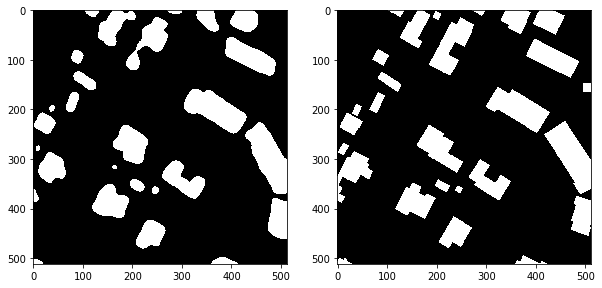

In [71]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(outputs > 127, cmap='gray')
axs[1].imshow(labels, cmap='gray')

In [26]:
train_dataset.datas[2]

'1.tif'

In [27]:
train_dataset.labels[2]

'1.tif'